In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# FIT5226 Project Stage 1 - Tabular Q-Learning for Single Agent

This notebook implements a tabular Q-learning algorithm to train an agent to complete a transport task in a grid world environment. The agent's goal is to pick up an item at location A and deliver it to location B with the fewest steps possible.

## Task 1: Environment and Task Description

### Environment Description

The environment is a 5x5 grid world where an agent must learn to complete a transport task. The agent's goal is to pick up an item located at a random position (A) within the grid and deliver it to a fixed goal location (B) in the bottom-right corner of the grid.

Note: We can configure the grid size in code. grid_size = 5 for computational simplicity.
#### State Space:
- The state space is defined by the following components:
  - **Agent's Position**: The current coordinates of the agent in the grid.
  - **Item Position (A)**: The coordinates of the item in the grid. This location is randomly determined at the start of each episode.
  - **Item Status**: A binary indicator representing whether the agent is carrying the item (True/False).

#### Action Space:
- The agent can perform one of four possible actions in each time step:
  - **Move North**: The agent moves one cell up.
  - **Move South**: The agent moves one cell down.
  - **Move East**: The agent moves one cell right.
  - **Move West**: The agent moves one cell left.

### Task Description

The agent begins each episode at a random location in the grid. The task is divided into two stages:
1. **Pickup Stage**: The agent must navigate the grid to reach the item at location A and pick it up.
2. **Delivery Stage**: After picking up the item, the agent must navigate to the goal location B and deliver the item.

The objective is to learn a policy that minimizes the number of steps taken to complete both stages of the task.

### Reward Structure

The reward structure is designed to effectively guide the agent in learning the task. The rewards and penalties are structured as follows:

- **Step Penalty (`-1`)**: The agent receives a small negative reward for each step it takes. This encourages the agent to find the shortest path to complete the task.

- **Boundary Penalty (`-5`)**: If the agent attempts to move outside the grid boundaries, it receives a larger negative reward. This penalty prevents the agent from making invalid moves.

- **Moving Away Penalty (`-2`)**: 
  - Before picking up the item at location A, if the agent moves away from A, it receives a negative reward.
  - After picking up the item, if the agent moves away from the goal location B, it also receives a negative reward. This encourages the agent to stay focused on reaching its goals.

- **Item Pickup Reward (`+10`)**: When the agent successfully reaches location A and picks up the item, it receives a positive reward. This reward reinforces the importance of picking up the item.

- **Goal Completion Reward (`+50`)**: The agent receives a large positive reward for successfully delivering the item to location B, completing the task. This reward signifies the successful completion of the agent's mission.


## Task 2: Environment Setup

In this task, we implement the `GridWorld` environment where the agent will operate. The environment is a square grid of size `n x n`. The agent's goal is to pick up an item at location A and deliver it to a fixed target location B, which is the bottom-right corner of the grid.

The environment includes:
- A grid of configurable size.
- An agent that can move in four directions: north, south, east, and west.
- An item that the agent must pick up at a randomly placed location A.
- A goal location B where the agent must deliver the item.

Import all the necessary libraries and packages. Here we only allow using Numpy and Matplotlib for the visualisation.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

The `GridWorld` class manages the environment's state, allows the agent to take actions, and provides feedback in the form of rewards and state transitions.

In [3]:
class GridWorld:
    def __init__(self, size=5, start=None, item_location=None, goal_location=None):
        self.size = size
        
        # Set goal location, fixed at the bottom-right corner by default
        self.goal_location = goal_location if goal_location else (size-1, size-1)
        
        # Set random start position if not provided
        self.start = start if start else (random.randint(0, size-1), random.randint(0, size-1))
        
        # Set random item location if not provided
        self.item_location = item_location if item_location else self._random_item_location()
        
        # Initialize the agent's position
        self.agent_position = self.start
        self.has_item = False

    def _random_item_location(self):
        """Generate a random item location that is not the same as the start or goal location."""
        while True:
            item_location = (random.randint(0, self.size-1), random.randint(0, self.size-1))
            if item_location != self.start and item_location != self.goal_location:
                return item_location

    def reset(self):
        """Resets the environment to the initial state."""
        self.agent_position = self.start
        self.has_item = False
        return self.get_state()

    def get_state(self):
        """Returns the current state of the environment."""
        return (self.agent_position, self.item_location, self.has_item)

    def step(self, action):
        """Executes an action and updates the environment."""
        reward = -1  # Default step penalty
        new_position = self.agent_position

        # Determine the agent's new position based on the action
        if action == 'north':
            new_position = (self.agent_position[0] - 1, self.agent_position[1])
        elif action == 'south':
            new_position = (self.agent_position[0] + 1, self.agent_position[1])
        elif action == 'east':
            new_position = (self.agent_position[0], self.agent_position[1] + 1)
        elif action == 'west':
            new_position = (self.agent_position[0], self.agent_position[1] - 1)

        # Check if the agent hits the grid boundary
        if (new_position[0] < 0 or new_position[0] >= self.size or
            new_position[1] < 0 or new_position[1] >= self.size):
            reward = -5  # Penalty for hitting the boundary
            new_position = self.agent_position  # Keep the agent in the same position
        else:
            self.agent_position = new_position

        # Check if the agent moves away from the goal (optional penalty)
        if not self.has_item:
            if abs(new_position[0] - self.item_location[0]) + abs(new_position[1] - self.item_location[1]) > \
               abs(self.agent_position[0] - self.item_location[0]) + abs(self.agent_position[1] - self.item_location[1]):
                reward = -2  # Penalty for moving away from item A
        else:
            if abs(new_position[0] - self.goal_location[0]) + abs(new_position[1] - self.goal_location[1]) > \
               abs(self.agent_position[0] - self.goal_location[0]) + abs(self.agent_position[1] - self.goal_location[1]):
                reward = -2  # Penalty for moving away from goal B

        # Check if the agent picks up the item
        if self.agent_position == self.item_location and not self.has_item:
            self.has_item = True
            reward = 10  # Reward for picking up the item

        # Check if the agent reaches the goal
        done = False
        if self.agent_position == self.goal_location and self.has_item:
            reward = 50  # Reward for completing the task
            done = True

        next_state = self.get_state()
        return next_state, reward, done

In [4]:
def print_grid(environment):
    """Prints the grid with the agent's start position, item location (A), and goal location (B)."""
    grid_size = environment.size
    grid = [['.' for _ in range(grid_size)] for _ in range(grid_size)]
    
    # Mark the agent's start position
    agent_pos = environment.start
    grid[agent_pos[0]][agent_pos[1]] = 'S'  # S for Start/Agent
    
    # Mark the item location (A)
    item_pos = environment.item_location
    grid[item_pos[0]][item_pos[1]] = 'A'
    
    # Mark the goal location (B)
    goal_pos = environment.goal_location
    grid[goal_pos[0]][goal_pos[1]] = 'B'
    
    # Print the grid
    for row in grid:
        print(' '.join(row))

# Initialize the grid world environment
env = GridWorld(size=100)

# Print the grid with start, A, B locations
print_grid(env)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


## Task 3: Q-learning Algorithm

In this task, we implement the `QLearningAgent` class that enables the agent to learn from its interactions with the environment. The Q-learning agent uses a table to store Q-values, which represent the expected future rewards for each state-action pair.

Key components of the Q-learning agent:
- **Q-Table**: Stores the Q-values for all state-action pairs.
- **Learning Rate (`alpha`)**: Controls how much new information overrides old information.
- **Discount Factor (`gamma`)**: Reflects how much future rewards are valued compared to immediate rewards.
- **Exploration Rate (`epsilon`)**: Balances exploration (trying new actions) and exploitation (using known actions with high rewards).

The agent learns by updating its Q-values based on the rewards received and the best future Q-values it can expect.

In [5]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, grid_size=5):
        """Initializes the Q-learning agent."""
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.grid_size = grid_size
        self.actions = ['north', 'south', 'east', 'west']

    def get_q_value(self, state, action):
        """Returns the Q-value for a given state-action pair."""
        return self.q_table.get((state, action), 0.0)

    def set_q_value(self, state, action, value):
        """Sets the Q-value for a given state-action pair."""
        self.q_table[(state, action)] = value

    def choose_action(self, state):
        """Chooses an action based on the epsilon-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            max_q = max(q_values)
            return self.actions[q_values.index(max_q)]

    def update_q_value(self, state, action, reward, next_state):
        """Updates the Q-value based on the received reward and next state."""
        next_q_values = [self.get_q_value(next_state, a) for a in self.actions]
        best_next_q = max(next_q_values)
        old_q_value = self.get_q_value(state, action)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * best_next_q - old_q_value)
        self.set_q_value(state, action, new_q_value)

In [6]:
# Initialize the Q-learning agent
agent = QLearningAgent(alpha=0.25, gamma=0.85, epsilon=0.1, grid_size=100)

## Task 4: Training Phase

In this task, we train the Q-learning agent by allowing it to interact with the `GridWorld` environment over multiple episodes. During each episode, the agent starts at a random position, attempts to pick up the item at location A, and deliver it to location B.

The training process involves:
- The agent taking actions based on its current policy (exploration vs. exploitation).
- Receiving rewards based on the outcomes of its actions.
- Updating the Q-values to improve future decisions.

The training continues over a large number of episodes, enabling the agent to learn an optimal policy that minimizes the number of steps needed to complete the task.

In [7]:
def train_agent(agent, environment, episodes=25000):
    """Trains the Q-learning agent."""
    for episode in range(episodes):
        state = environment.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1} completed.")

# Train the agent for a specified number of episodes
train_agent(agent, env, episodes=25000)

Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Episode 1000 completed.
Episode 1100 completed.
Episode 1200 completed.
Episode 1300 completed.
Episode 1400 completed.
Episode 1500 completed.
Episode 1600 completed.
Episode 1700 completed.
Episode 1800 completed.
Episode 1900 completed.
Episode 2000 completed.
Episode 2100 completed.
Episode 2200 completed.
Episode 2300 completed.
Episode 2400 completed.
Episode 2500 completed.
Episode 2600 completed.
Episode 2700 completed.
Episode 2800 completed.
Episode 2900 completed.
Episode 3000 completed.
Episode 3100 completed.
Episode 3200 completed.
Episode 3300 completed.
Episode 3400 completed.
Episode 3500 completed.
Episode 3600 completed.
Episode 3700 completed.
Episode 3800 completed.
Episode 3900 completed.
Episode 4000 completed.
Episode 4100 completed.
Episode 4200 completed.
E

## Task 5: Evaluation Phase

This phase include testing phase and calculation of all the metrics required to evaluate the performance.

#### A) The testing process includes:
- Running the agent for a number of trials starting from different positions.


In [8]:
def test_agent(agent, environment, trials=100):
    """Tests the Q-learning agent after training and returns total steps taken."""
    total_steps = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        steps = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
            steps += 1
        total_steps += steps
    return total_steps

# Test the agent
total_steps = test_agent(agent, env, trials=100)

#### B) The performance metrics includes:
1. **Average Steps to Complete the Task**: Measures the average number of steps the agent takes to complete the task. Fewer steps indicate better learning.

2. **Success Rate**: The percentage of trials in which the agent successfully completes the task. A higher success rate means the agent is reliably achieving its goal.

3. **Convergence of Q-values**: Tracks how Q-values for specific state-action pairs stabilize over time, indicating the agent has learned a consistent policy.

4. **Path Efficiency**: Analyzes how often the agent takes the shortest possible path to complete the task. Higher efficiency reflects better decision-making.

5. **Exploration vs. Exploitation Rate**: Monitors the balance between the agent exploring new actions and exploiting known actions to maximize rewards.

These metrics help us assess the effectiveness of the training and the agent's ability to generalize its learned policy to new situations.

Average steps taken: 179.42
Success rate: 100.0%


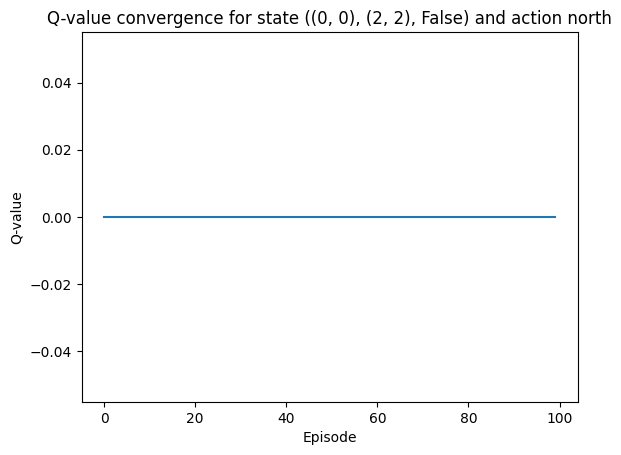

Path efficiency: 0.0%
Exploration rate: 10.02006266349408%
Exploitation rate: 89.97993733650593%


In [9]:
def calculate_average_steps(total_steps, trials):
    """Calculates the average steps taken based on total steps and number of trials."""
    average_steps = total_steps / trials
    print(f"Average steps taken: {average_steps}")
    return average_steps


def success_rate(agent, environment, trials=100):
    successful_trials = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
        if state[0] == environment.goal_location and environment.has_item:
            successful_trials += 1
    return successful_trials / trials * 100



def q_value_convergence(agent, state, action):
    q_values = []
    for _ in range(100):
        q_values.append(agent.get_q_value(state, action))
    plt.plot(q_values)
    plt.title(f'Q-value convergence for state {state} and action {action}')
    plt.xlabel('Episode')
    plt.ylabel('Q-value')
    plt.show()

# considering  manhattan distance is the optimal path   
def path_efficiency(agent, environment, trials=100):
    efficient_paths = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        steps = 0
        
        # Calculate the optimal number of steps dynamically
        optimal_steps = (abs(environment.start[0] - environment.item_location[0]) +
                         abs(environment.start[1] - environment.item_location[1]) +
                         abs(environment.item_location[0] - environment.goal_location[0]) +
                         abs(environment.item_location[1] - environment.goal_location[1]))
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
            steps += 1
            
        if steps == optimal_steps:
            efficient_paths += 1
    
    return efficient_paths / trials * 100


def exploration_exploitation_rate(agent, environment, episodes=1000):
    exploration_count = 0
    exploitation_count = 0
    for episode in range(episodes):
        state = environment.reset()
        done = False
        while not done:
            if random.uniform(0, 1) < agent.epsilon:
                exploration_count += 1
            else:
                exploitation_count += 1
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
    exploration_rate = exploration_count / (exploration_count + exploitation_count) * 100
    exploitation_rate = exploitation_count / (exploration_count + exploitation_count) * 100
    return exploration_rate, exploitation_rate

calculate_average_steps(total_steps, trials=100)

success_rate_percentage = success_rate(agent, environment = env, trials=100)
print(f"Success rate: {success_rate_percentage}%")

q_value_convergence(agent, state=((0, 0), (2, 2), False), action='north')

efficiency_percentage = path_efficiency(agent, env, trials=100)
print(f"Path efficiency: {efficiency_percentage}%")

exploration_rate, exploitation_rate = exploration_exploitation_rate(agent, env)
print(f"Exploration rate: {exploration_rate}%")
print(f"Exploitation rate: {exploitation_rate}%")



## Task 6: Visualization:

The visualization process involves:
- Plotting the agent's path on the grid for several episodes.
- Displaying the number of times the agent visits each cell in the grid.
- Showing how the agent's behavior changes as it learns over time.

These visualizations help us understand whether the agent is effectively learning to optimize its movements and complete the task efficiently.

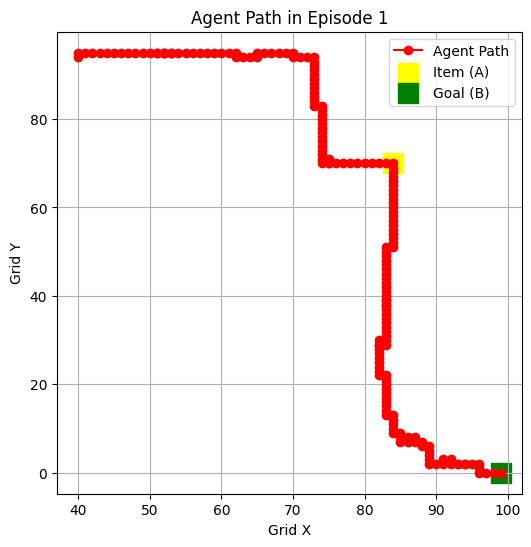

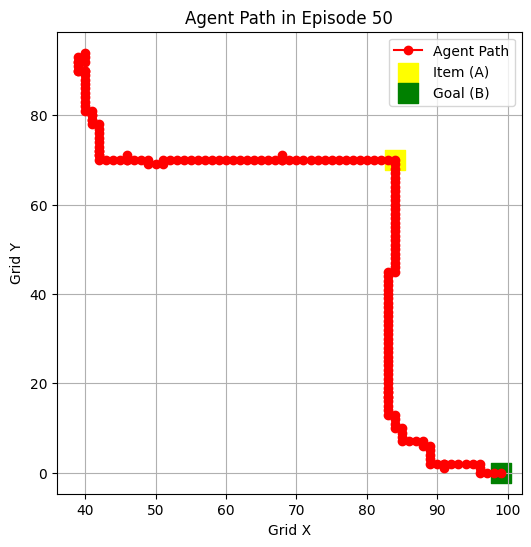

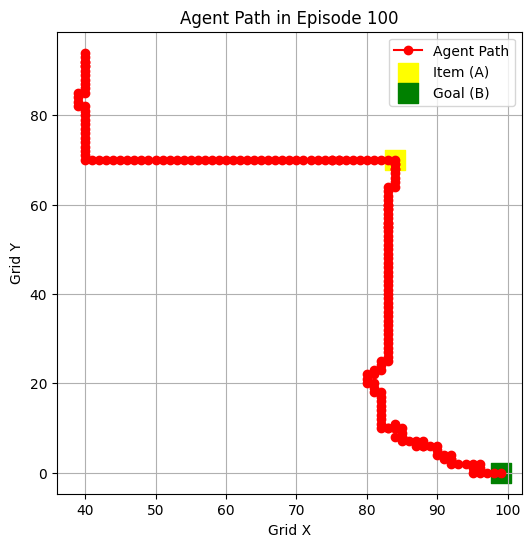

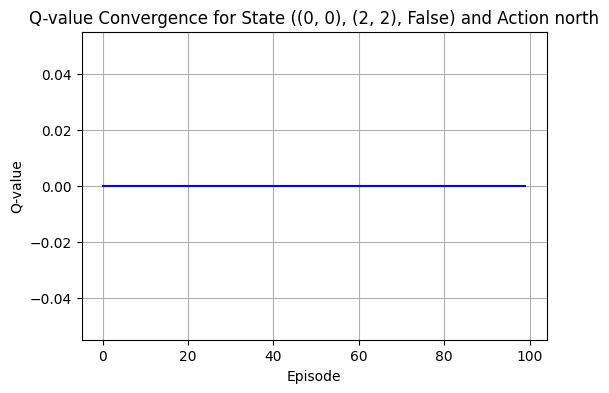

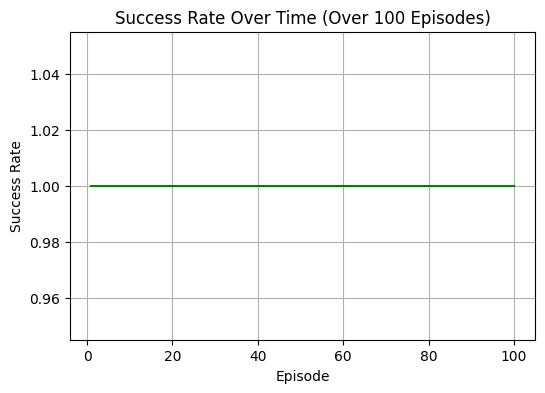

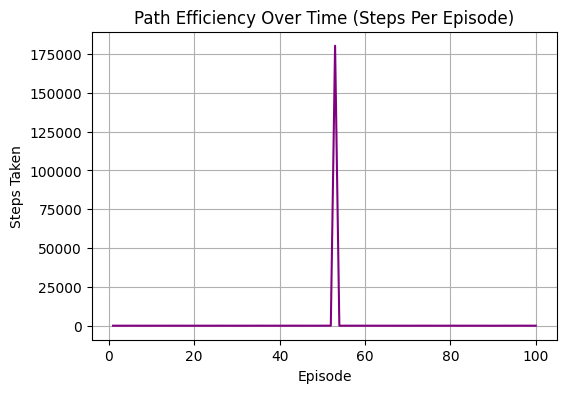

In [10]:
def visualize_multiple_episodes(agent, environment, episodes=[0, 50, 99]):
    """Visualizes the agent's path in selected episodes."""
    for episode in episodes:
        state = environment.reset()
        path = [state[0]]
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            path.append(next_state[0])
            state = next_state
        
        # Plotting the path
        plt.figure(figsize=(6, 6))
        x_coords = [pos[1] for pos in path]
        y_coords = [environment.size - 1 - pos[0] for pos in path]
        plt.plot(x_coords, y_coords, marker='o', color='red', label='Agent Path')
        plt.scatter([environment.item_location[1]], [environment.size - 1 - environment.item_location[0]], color='yellow', s=200, label='Item (A)', marker='s')
        plt.scatter([environment.goal_location[1]], [environment.size - 1 - environment.goal_location[0]], color='green', s=200, label='Goal (B)', marker='s')
        plt.title(f'Agent Path in Episode {episode + 1}')
        plt.xlabel('Grid X')
        plt.ylabel('Grid Y')
        plt.legend()
        plt.grid(True)
        plt.show()

# Visualize paths in episodes 1, 50, and 100
visualize_multiple_episodes(agent, env, episodes=[0, 49, 99])

def q_value_convergence(agent, state, action, episodes=100):
    """Plots the Q-value convergence for a given state-action pair over a number of episodes."""
    q_values = []
    for episode in range(episodes):
        agent.choose_action(state)  # Simulate agent's choice to update Q-values
        q_values.append(agent.get_q_value(state, action))
    
    plt.figure(figsize=(6, 4))
    plt.plot(q_values, color='blue')
    plt.title(f'Q-value Convergence for State {state} and Action {action}')
    plt.xlabel('Episode')
    plt.ylabel('Q-value')
    plt.grid(True)
    plt.show()

# Example of checking Q-value convergence for a specific state-action pair
q_value_convergence(agent, state=((0, 0), (2, 2), False), action='north', episodes=100)

def plot_success_rate(agent, environment, episodes=100):
    """Plots the success rate of the agent over a number of episodes."""
    success_counts = []
    for episode in range(episodes):
        success = 0
        state = environment.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
        if state[0] == environment.goal_location and environment.has_item:
            success += 1
        success_counts.append(success)
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, episodes + 1), np.cumsum(success_counts) / np.arange(1, episodes + 1), color='green')
    plt.title(f'Success Rate Over Time (Over {episodes} Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.grid(True)
    plt.show()

# Plot success rate over 100 episodes
plot_success_rate(agent, env, episodes=100)

def plot_path_efficiency(agent, environment, episodes=100):
    """Plots the path efficiency of the agent over a number of episodes."""
    step_counts = []
    for episode in range(episodes):
        state = environment.reset()
        steps = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
            steps += 1
        step_counts.append(steps)
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, episodes + 1), step_counts, color='purple')
    plt.title(f'Path Efficiency Over Time (Steps Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.grid(True)
    plt.show()

# Plot path efficiency over 100 episodes
plot_path_efficiency(agent, env, episodes=100)